#Paquetes necesarios

Podremos hacer uso del mismo *environment* de la primera práctica, aunque en ocasiones pedirá instalar Pillow

In [1]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

Carga imagen desde archivo y convierte a RGB

(512, 512, 3)


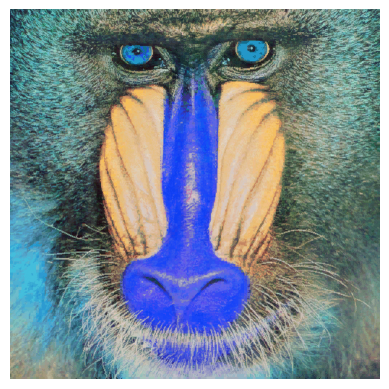

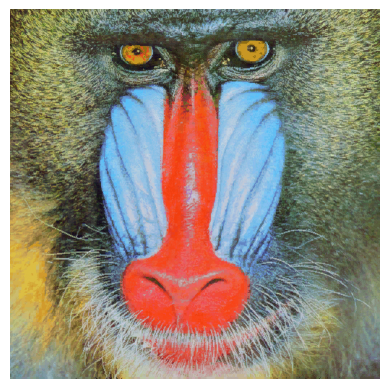

In [2]:
#Lee imagen de archivo
img = cv2.imread('mandril.jpg') 

#Si hay lectura correcta
if img is not None:
    #Muestra dimensiones
    print(img.shape)
    #Muestra la imagen original con matplotlib
    plt.figure()
    #Elimina etiquetas de los ejes que muestra matplotlib
    plt.axis("off")
    plt.imshow(img) 
    plt.show()

    #Recordar que OpenCV lee las imágenes almacenando en formato BGR, por lo que convertimos para visualizr de forma correcta a RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Muestra la imagen tras convertir a RGB
    #Eliminamos etiquetas de los ejes
    plt.figure()
    plt.axis("off")
    plt.imshow(img_rgb) 
    plt.show()
else: 
    print('Imagen no encontrada')

TAREA: Realiza la cuenta de píxeles blancos por filas (en lugar de por columnas). Determina el valor máximo de píxeles blancos para filas, maxfil, mostrando el número de filas y sus respectivas posiciones, con un número de píxeles blancos mayor o igual que 0.90*maxfil.

(0.0, 512.0)

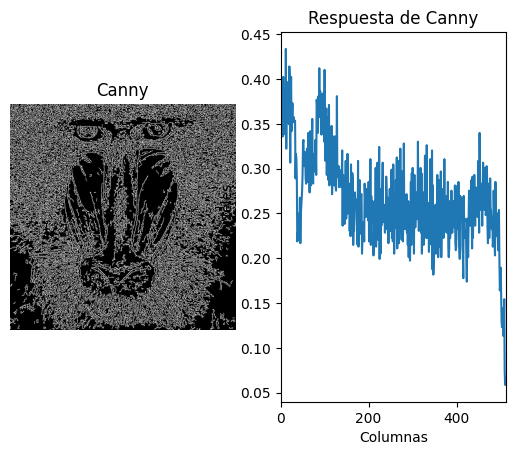

In [58]:
canny = cv2.Canny(img, 100, 200)
#El contenido de la imagen resultado de Canny, son valores 0 o 255, lo compruebas al descomentar
#print(canny)
#Cuenta el número de píxeles blancos (255) por columna
#Suma los valores de los pixeles por columna
col_counts = cv2.reduce(canny, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
row_counts = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)

#Normaliza en base al número de filas, primer valor devuelto por shape, y al valor máximo del píxel (255)
#El resultado será el número de píxeles blancos por columna
rows = col_counts[:,] / (255 * canny.shape[0])
cols = row_counts[:,] / (255 * canny.shape[1])

#Muestra dicha cuenta gráficamente
plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Canny")
plt.imshow(canny, cmap='gray') 

plt.subplot(1, 2, 2)
plt.title("Respuesta de Canny")
plt.xlabel("Columnas")
plt.ylabel("% píxeles")
plt.plot(cols)
#Rango en x definido por las columnas
plt.xlim([0, canny.shape[0]])

TAREA: Aplica umbralizado a la imagen resultante de Sobel (convertida a 8 bits), y posteriormente realiza el conteo por filas y columnas similar al realizado en el ejemplo con la salida de Canny de píxeles no nulos. Calcula el valor máximo de la cuenta por filas y columnas, y determina las filas y columnas por encima del 0.90*máximo. Remarca con alguna primitiva gráfica dichas filas y columnas sobre la imagen del mandril. ¿Cómo se comparan los resultados obtenidos a partir de Sobel y Canny?

Filas destacadas: [ 3 19]


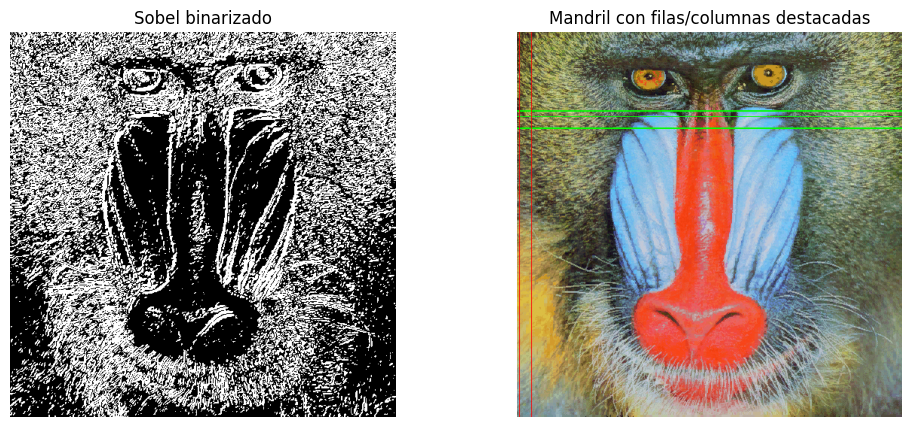

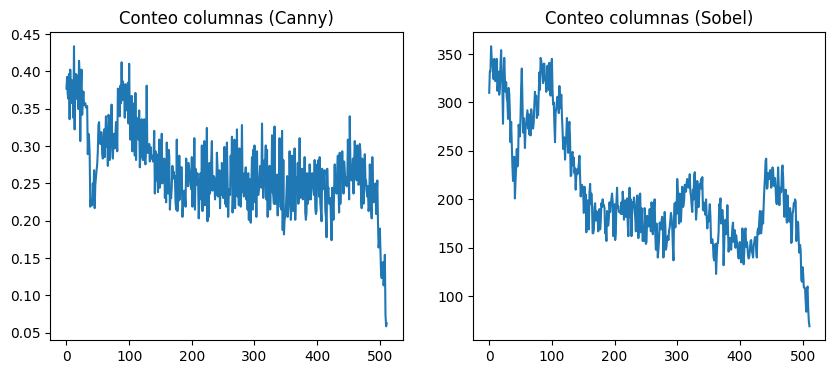

In [79]:
# Aplica Sobel y umbralizado
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ggris = cv2.GaussianBlur(gris, (3, 3), 0)
sobelx = cv2.Sobel(ggris, cv2.CV_64F, 1, 0)
sobely = cv2.Sobel(ggris, cv2.CV_64F, 0, 1)
sobel = cv2.add(sobelx, sobely)
sobel_8u = cv2.convertScaleAbs(sobel)
_, sobel_bin = cv2.threshold(sobel_8u, 50, 255, cv2.THRESH_BINARY)

# Conteo por filas y columnas
row_counts_sobel = np.count_nonzero(sobel_bin, axis=1)
col_counts_sobel = np.count_nonzero(sobel_bin, axis=0)

# Máximos y umbral del 90%
max_rows = np.max(row_counts_sobel)
max_cols = np.max(col_counts_sobel)
umbral_rows = 0.98 * max_rows
umbral_cols = 0.98 * max_cols

# Filas y columnas destacadas
filas_destacadas = np.where(row_counts_sobel >= umbral_rows)[0]
columnas_destacadas = np.where(col_counts_sobel >= umbral_cols)[0]

# Remarca filas y columnas sobre la imagen original
img_marcada = img.copy()
for row in columnas_destacadas:
    cv2.line(img_marcada, (0, row), (img.shape[1]-1, row), (0,255,0), 1)
for col in filas_destacadas:
    cv2.line(img_marcada, (col, 0), (col, img.shape[0]-1), (0,0,255), 1)

print(f"Filas destacadas: {filas_destacadas}")
# Visualización
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Sobel binarizado")
plt.axis("off")
plt.imshow(sobel_bin, cmap='gray')
plt.subplot(1,2,2)
plt.title("Mandril con filas/columnas destacadas")
plt.axis("off")
plt.imshow(cv2.cvtColor(img_marcada, cv2.COLOR_BGR2RGB))
plt.show()

# Comparación con Canny
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Conteo columnas (Canny)")
plt.plot(cols)
plt.subplot(1,2,2)
plt.title("Conteo columnas (Sobel)")
plt.plot(row_counts_sobel)
plt.show()

Diferencia de imágenes

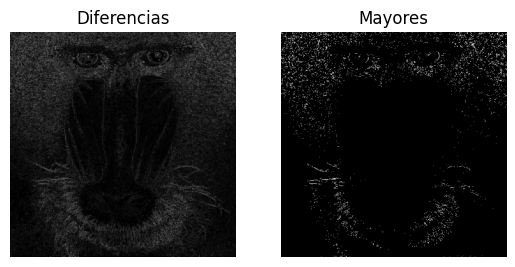

In [ ]:
#Calcula la diferencia entre dos imágenes
#Utiliza la imagen original y la obtenida tras aplicar la gaussiana (creada en la celda dedicada a Sobel)
dif = cv2.absdiff(gris, ggris)

#Visualiza
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Diferencias")
plt.axis("off")
plt.imshow(dif, cmap='gray') 

#Zonas de mayor diferencia tras aplicar umbral
res, imgdif = cv2.threshold(dif, 30, 255, cv2.THRESH_BINARY)
#Visualiza
plt.subplot(1, 2, 2)
plt.title("Mayores")
plt.axis("off")
plt.imshow(imgdif, cmap='gray') 
plt.show()


Webcam y sustracción de fotogramas

In [ ]:
vid = cv2.VideoCapture(0)

#Marca de inicio
disponible = 0 
while(True):      
    # fotograma a fotograma
    ret, frame = vid.read()

    if ret:
        if disponible > 0:
            dif = cv2.absdiff(frame, pframe)        
            # Muestra resultado
            cv2.imshow('Diferencia', dif)    
        else:
            disponible = 1

        #Copia fotograma actual para la diferencia en el siguiente forograma
        pframe = frame.copy()
    # Detenemos pulsado ESC
    if cv2.waitKey(20) == 27:
        break
  
# Libera el objeto de captura
vid.release()
# Destruye ventanas
cv2.destroyAllWindows()

Webcam y sustracción de modelo del fondo

In [37]:
vid = cv2.VideoCapture(0)

# Fondo
# Inicializa la sustracción del fondo con mezcla de gaussianas y detección de sombras
eliminadorFondo = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=50, detectShadows=True)
  
while(True):      
    # fotograma a fotograma
    ret, frame = vid.read()

    if ret:
        # Aplica efecto espejo sobre la entrada
        framem=cv2.flip(frame, 1)

        
        #Con un segundo parámerto se puede definir máscara con zonas a actualizar
        objetos = eliminadorFondo.apply(framem)
        #objetos = eliminadorFondo.apply(framem, objetos, 0)  #No actualiza el fondo
        # Obtiene fondo
        background = eliminadorFondo.getBackgroundImage()

        # Muestra resultado
        cv2.imshow('Fotograma', objetos)
        # Muestra fondo
        cv2.imshow('Fondo', background)
  
   
    # Detenemos pulsado ESC
    if cv2.waitKey(20) == 27:
        break
  
# Libera el objeto de captura
vid.release()
# Destruye ventanas
cv2.destroyAllWindows()


TAREA: Proponer un demostrador que capture las imágenes de la cámara, y les permita exhibir lo aprendido en estas dos prácticas ante quienes no cursen la asignatura :). Es por ello que además de poder mostrar la imagen original de la webcam, permita cambiar de modo, incluyendo al menos dos procesamientos diferentes como resultado de aplicar las funciones de OpenCV trabajadas hasta ahora.


TAREA: Tras ver los vídeos [My little piece of privacy](https://www.niklasroy.com/project/88/my-little-piece-of-privacy), [Messa di voce](https://youtu.be/GfoqiyB1ndE?feature=shared) y [Virtual air guitar](https://youtu.be/FIAmyoEpV5c?feature=shared) proponer un demostrador reinterpretando la parte de procesamiento de la imagen, tomando como punto de partida alguna de dichas instalaciones.